<a href="https://colab.research.google.com/github/ShepherdCode/ShepherdML/blob/master/Nasa2021/LSTM_403.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM 403
Start with LSTM 201 and modify it to use our updated code infrastructure.

In [1]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
MODEL_FILE='LSTM302'   # load not save!
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=100
SPLITS=1
K=3
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
NEURONS=16
DROP=0.25
ACT="tanh"

Mounted at /content/drive/


In [2]:
# Load our own tools
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [4]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    embed_layer  = keras.layers.Embedding(
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
        input_dim=VOCABULARY_SIZE, output_dim=EMBED_DIMEN, mask_zero=True)
    rnn1_layer = keras.layers.Bidirectional(
      keras.layers.LSTM(NEURONS, return_sequences=True, 
          input_shape=[1000,EMBED_DIMEN], activation=ACT, dropout=DROP) )#bi
    rnn2_layer = keras.layers.Bidirectional(
      keras.layers.LSTM(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP) )#bi
    dense1_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop1_layer = keras.layers.Dropout(DROP)
    dense2_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop2_layer = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)
    mlp = keras.models.Sequential()
    mlp.add(embed_layer)
    mlp.add(rnn1_layer)
    mlp.add(rnn2_layer)
    mlp.add(dense1_layer)
    mlp.add(drop1_layer)
    mlp.add(dense2_layer)
    mlp.add(drop2_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

Partition sequences

In [5]:
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

Cross validation

In [6]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [7]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=tools.make_kmers(K,MAXLEN,subset)
#print ("Data prep")
#X_train=tools.make_frequencies(K,X_train)

Load data from files.
Ready: train_set
Data reshape


In [8]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          1040      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 32)          4224      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_____________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 81s 139ms/step - loss: 0.6233 - accuracy: 0.6681 - val_loss: 0.5548 - val_accuracy: 0.7300


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 2/100
453/453 [==============================] - 60s 132ms/step - loss: 0.5661 - accuracy: 0.7190 - val_loss: 0.5594 - val_accuracy: 0.7182
Epoch 3/100
453/453 [==============================] - 59s 129ms/step - loss: 0.5594 - accuracy: 0.7205 - val_loss: 0.5159 - val_accuracy: 0.7616


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 4/100
453/453 [==============================] - 59s 129ms/step - loss: 0.5431 - accuracy: 0.7349 - val_loss: 0.5083 - val_accuracy: 0.7672


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 5/100
453/453 [==============================] - 59s 131ms/step - loss: 0.5619 - accuracy: 0.7291 - val_loss: 0.5178 - val_accuracy: 0.7511
Epoch 6/100
453/453 [==============================] - 60s 131ms/step - loss: 0.5446 - accuracy: 0.7390 - val_loss: 0.5474 - val_accuracy: 0.6822
Epoch 7/100
453/453 [==============================] - 59s 129ms/step - loss: 0.6063 - accuracy: 0.6842 - val_loss: 0.5875 - val_accuracy: 0.7064
Epoch 8/100
453/453 [==============================] - 60s 132ms/step - loss: 0.5957 - accuracy: 0.6915 - val_loss: 0.5496 - val_accuracy: 0.7349
Epoch 9/100
453/453 [==============================] - 59s 130ms/step - loss: 0.5694 - accuracy: 0.7031 - val_loss: 0.6566 - val_accuracy: 0.6046
Epoch 10/100
453/453 [==============================] - 60s 132ms/step - loss: 0.5750 - accuracy: 0.7073 - val_loss: 0.5088 - val_accuracy: 0.7610
Epoch 11/100
453/453 [==============================] - 60s 131ms/step - loss: 0.5303 - accuracy: 0.7481 - val_loss: 0.5125

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 14/100
453/453 [==============================] - 59s 130ms/step - loss: 0.4755 - accuracy: 0.7798 - val_loss: 0.4518 - val_accuracy: 0.7790
Epoch 15/100
453/453 [==============================] - 58s 127ms/step - loss: 0.4637 - accuracy: 0.7763 - val_loss: 0.4241 - val_accuracy: 0.8001
Epoch 16/100
453/453 [==============================] - 59s 130ms/step - loss: 0.4509 - accuracy: 0.7797 - val_loss: 0.4039 - val_accuracy: 0.8144


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 17/100
453/453 [==============================] - 60s 132ms/step - loss: 0.4548 - accuracy: 0.7830 - val_loss: 0.4016 - val_accuracy: 0.8107
Epoch 18/100
453/453 [==============================] - 59s 131ms/step - loss: 0.4127 - accuracy: 0.8173 - val_loss: 0.3828 - val_accuracy: 0.8237


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 19/100
453/453 [==============================] - 59s 131ms/step - loss: 0.4110 - accuracy: 0.8199 - val_loss: 0.3730 - val_accuracy: 0.8281


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 20/100
453/453 [==============================] - 59s 130ms/step - loss: 0.4155 - accuracy: 0.8162 - val_loss: 0.3930 - val_accuracy: 0.8318


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 21/100
453/453 [==============================] - 59s 130ms/step - loss: 0.4002 - accuracy: 0.8238 - val_loss: 0.3720 - val_accuracy: 0.8262
Epoch 22/100
453/453 [==============================] - 60s 131ms/step - loss: 0.4028 - accuracy: 0.8266 - val_loss: 0.3660 - val_accuracy: 0.8324


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 23/100
453/453 [==============================] - 59s 130ms/step - loss: 0.3978 - accuracy: 0.8258 - val_loss: 0.3885 - val_accuracy: 0.8194
Epoch 24/100
453/453 [==============================] - 60s 132ms/step - loss: 0.3897 - accuracy: 0.8305 - val_loss: 0.3961 - val_accuracy: 0.8274
Epoch 25/100
453/453 [==============================] - 60s 133ms/step - loss: 0.4024 - accuracy: 0.8250 - val_loss: 0.3725 - val_accuracy: 0.8343


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 26/100
453/453 [==============================] - 60s 133ms/step - loss: 0.3967 - accuracy: 0.8249 - val_loss: 0.3788 - val_accuracy: 0.8268
Epoch 27/100
453/453 [==============================] - 61s 134ms/step - loss: 0.4038 - accuracy: 0.8242 - val_loss: 0.3790 - val_accuracy: 0.8231
Epoch 28/100
453/453 [==============================] - 60s 133ms/step - loss: 0.3920 - accuracy: 0.8280 - val_loss: 0.3764 - val_accuracy: 0.8274
Epoch 29/100
453/453 [==============================] - 60s 132ms/step - loss: 0.3789 - accuracy: 0.8350 - val_loss: 0.3541 - val_accuracy: 0.8442


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 30/100
453/453 [==============================] - 60s 132ms/step - loss: 0.3815 - accuracy: 0.8355 - val_loss: 0.3716 - val_accuracy: 0.8355
Epoch 31/100
453/453 [==============================] - 60s 133ms/step - loss: 0.3951 - accuracy: 0.8259 - val_loss: 0.3575 - val_accuracy: 0.8361
Epoch 32/100
453/453 [==============================] - 59s 130ms/step - loss: 0.3856 - accuracy: 0.8327 - val_loss: 0.3586 - val_accuracy: 0.8374
Epoch 33/100
453/453 [==============================] - 59s 130ms/step - loss: 0.3799 - accuracy: 0.8387 - val_loss: 0.3595 - val_accuracy: 0.8367
Epoch 34/100
453/453 [==============================] - 59s 130ms/step - loss: 0.3846 - accuracy: 0.8315 - val_loss: 0.3553 - val_accuracy: 0.8417
Epoch 35/100
453/453 [==============================] - 59s 130ms/step - loss: 0.3823 - accuracy: 0.8356 - val_loss: 0.3481 - val_accuracy: 0.8417
Epoch 36/100
453/453 [==============================] - 60s 132ms/step - loss: 0.3826 - accuracy: 0.8361 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 45/100
453/453 [==============================] - 59s 129ms/step - loss: 0.3575 - accuracy: 0.8479 - val_loss: 0.3397 - val_accuracy: 0.8510
Epoch 46/100
453/453 [==============================] - 60s 132ms/step - loss: 0.3672 - accuracy: 0.8431 - val_loss: 0.3395 - val_accuracy: 0.8510
Epoch 47/100
453/453 [==============================] - 57s 125ms/step - loss: 0.3605 - accuracy: 0.8531 - val_loss: 0.3373 - val_accuracy: 0.8554


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 48/100
453/453 [==============================] - 57s 126ms/step - loss: 0.3586 - accuracy: 0.8481 - val_loss: 0.3438 - val_accuracy: 0.8498
Epoch 49/100
453/453 [==============================] - 58s 128ms/step - loss: 0.3480 - accuracy: 0.8516 - val_loss: 0.3598 - val_accuracy: 0.8535
Epoch 50/100
453/453 [==============================] - 57s 127ms/step - loss: 0.3555 - accuracy: 0.8489 - val_loss: 0.3322 - val_accuracy: 0.8523
Epoch 51/100
453/453 [==============================] - 59s 130ms/step - loss: 0.3530 - accuracy: 0.8502 - val_loss: 0.3419 - val_accuracy: 0.8523
Epoch 52/100
453/453 [==============================] - 58s 129ms/step - loss: 0.3460 - accuracy: 0.8529 - val_loss: 0.3390 - val_accuracy: 0.8485
Epoch 53/100
453/453 [==============================] - 59s 130ms/step - loss: 0.3416 - accuracy: 0.8526 - val_loss: 0.3255 - val_accuracy: 0.8641


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 54/100
453/453 [==============================] - 59s 131ms/step - loss: 0.3410 - accuracy: 0.8565 - val_loss: 0.3366 - val_accuracy: 0.8454
Epoch 55/100
453/453 [==============================] - 59s 130ms/step - loss: 0.3465 - accuracy: 0.8535 - val_loss: 0.3265 - val_accuracy: 0.8529
Epoch 56/100
453/453 [==============================] - 59s 131ms/step - loss: 0.3423 - accuracy: 0.8597 - val_loss: 0.3200 - val_accuracy: 0.8641
Epoch 57/100
453/453 [==============================] - 59s 129ms/step - loss: 0.3459 - accuracy: 0.8527 - val_loss: 0.3251 - val_accuracy: 0.8579
Epoch 58/100
453/453 [==============================] - 59s 130ms/step - loss: 0.3348 - accuracy: 0.8595 - val_loss: 0.3147 - val_accuracy: 0.8734


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 59/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3417 - accuracy: 0.8546 - val_loss: 0.3157 - val_accuracy: 0.8628
Epoch 60/100
453/453 [==============================] - 58s 128ms/step - loss: 0.3361 - accuracy: 0.8606 - val_loss: 0.3165 - val_accuracy: 0.8696
Epoch 61/100
453/453 [==============================] - 57s 125ms/step - loss: 0.3257 - accuracy: 0.8658 - val_loss: 0.3122 - val_accuracy: 0.8703
Epoch 62/100
453/453 [==============================] - 57s 125ms/step - loss: 0.3324 - accuracy: 0.8595 - val_loss: 0.3221 - val_accuracy: 0.8622
Epoch 63/100
453/453 [==============================] - 57s 126ms/step - loss: 0.3287 - accuracy: 0.8624 - val_loss: 0.3140 - val_accuracy: 0.8734
Epoch 64/100
453/453 [==============================] - 57s 125ms/step - loss: 0.3315 - accuracy: 0.8598 - val_loss: 0.3091 - val_accuracy: 0.8684
Epoch 65/100
453/453 [==============================] - 57s 126ms/step - loss: 0.3181 - accuracy: 0.8690 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 77/100
453/453 [==============================] - 58s 128ms/step - loss: 0.3035 - accuracy: 0.8756 - val_loss: 0.3036 - val_accuracy: 0.8771


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 78/100
453/453 [==============================] - 57s 127ms/step - loss: 0.3067 - accuracy: 0.8729 - val_loss: 0.3037 - val_accuracy: 0.8740
Epoch 79/100
453/453 [==============================] - 57s 126ms/step - loss: 0.3038 - accuracy: 0.8798 - val_loss: 0.3031 - val_accuracy: 0.8752
Epoch 80/100
453/453 [==============================] - 57s 126ms/step - loss: 0.3032 - accuracy: 0.8767 - val_loss: 0.3136 - val_accuracy: 0.8653
Epoch 81/100
453/453 [==============================] - 57s 126ms/step - loss: 0.2983 - accuracy: 0.8785 - val_loss: 0.2985 - val_accuracy: 0.8715
Epoch 82/100
453/453 [==============================] - 57s 126ms/step - loss: 0.2991 - accuracy: 0.8806 - val_loss: 0.2987 - val_accuracy: 0.8740
Epoch 83/100
453/453 [==============================] - 58s 128ms/step - loss: 0.2979 - accuracy: 0.8800 - val_loss: 0.3005 - val_accuracy: 0.8746
Epoch 84/100
453/453 [==============================] - 56s 125ms/step - loss: 0.2894 - accuracy: 0.8857 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 92/100
453/453 [==============================] - 56s 124ms/step - loss: 0.2815 - accuracy: 0.8870 - val_loss: 0.2947 - val_accuracy: 0.8746
Epoch 93/100
453/453 [==============================] - 55s 122ms/step - loss: 0.2833 - accuracy: 0.8859 - val_loss: 0.3015 - val_accuracy: 0.8696
Epoch 94/100
453/453 [==============================] - 57s 125ms/step - loss: 0.2830 - accuracy: 0.8840 - val_loss: 0.2944 - val_accuracy: 0.8721
Epoch 95/100
453/453 [==============================] - 57s 126ms/step - loss: 0.2775 - accuracy: 0.8897 - val_loss: 0.3210 - val_accuracy: 0.8672
Epoch 96/100
453/453 [==============================] - 58s 128ms/step - loss: 0.2828 - accuracy: 0.8853 - val_loss: 0.3145 - val_accuracy: 0.8684
Epoch 97/100
453/453 [==============================] - 57s 127ms/step - loss: 0.2826 - accuracy: 0.8846 - val_loss: 0.2976 - val_accuracy: 0.8759
Epoch 98/100
453/453 [==============================] - 57s 125ms/step - loss: 0.2819 - accuracy: 0.8832 - val_loss: 0

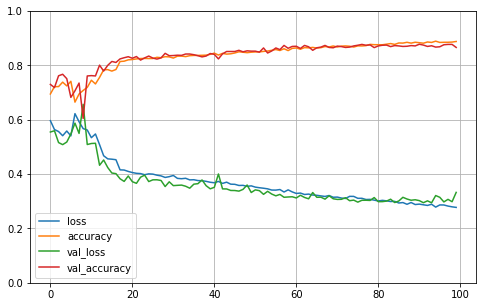

accuracy: 87.77%

1-way Cross Validation mean 87.77% (+/- 0.00%)
Done


In [9]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")